In [1]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import corner
from bilby.core.prior import Constraint, PriorDict, Uniform, Sine
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model


In [2]:
bands = ['lsstg', 'lsstr', 'lssti','lsstz','lssty', 'lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

[5000000000.0,
 308738116672272.25,
 344949774531146.6,
 397287890568202.3,
 481730482385753.06,
 621093082892117.8,
 816711949886849.0,
 1146839759677006.2,
 2e+17]

In [39]:
#priors

that_priorsoff = redback.priors.get_priors(model='tophat')
that_priorsoff['p']=  2.3
that_priorsoff['loge0']= Uniform(minimum=47, maximum=52, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorsoff['redshift']= 0.01
that_priorsoff['logepse']= -1.25
that_priorsoff['logepsb']= -2.5
that_priorsoff['ksin']= 1.0
that_priorsoff['g0']= 1000
that_priorsoff['logn0']=Uniform(minimum=-2, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)

that_priorson = redback.priors.get_priors(model='tophat')
that_priorson['p']=  2.3
that_priorson['loge0']= Uniform(minimum=46, maximum=50, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorson['redshift']= 0.01
that_priorson['logepse']= -1.25
that_priorson['logepsb']= -2.5
that_priorson['ksin']= 1.0
that_priorson['g0']= 1000
that_priorson['logn0']=Uniform(minimum=-2.5, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
that_priorson['thv']=Sine(minimum=0, maximum=0.3, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)

kn_priors = redback.priors.get_priors(model='two_layer_stratified_kilonova')
kn_priors['redshift']=0.01
samples=kn_priors.sample(30)
kn_data= pd.DataFrame.from_dict(samples)
kn_priors

{'redshift': DeltaFunction(peak=0.01, name=None, latex_label=None, unit=None),
 'mej': Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None),
 'vej_1': Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None),
 'vej_2': Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None),
 'kappa': Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None),
 'beta': Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)}

In [36]:
def afterglowoff(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.84, loge0=49.2 , thc= 0.06, logn0=0.05, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def afterglowon(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.14, loge0=47.7 , thc= 0.06, logn0=0.35, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def sampleoff(time,frequency):
    sample=that_priorsoff.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]<= 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorsoff.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def sampleon(time,frequency):
    sample=that_priorson.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]> 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorson.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def knsample(time, frequency, **sample):
    kn_fluxd =  redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
        base_model='two_layer_stratified_kilonova', output_format='flux_density', frequency=frequency, **sample)
   
    return kn_fluxd



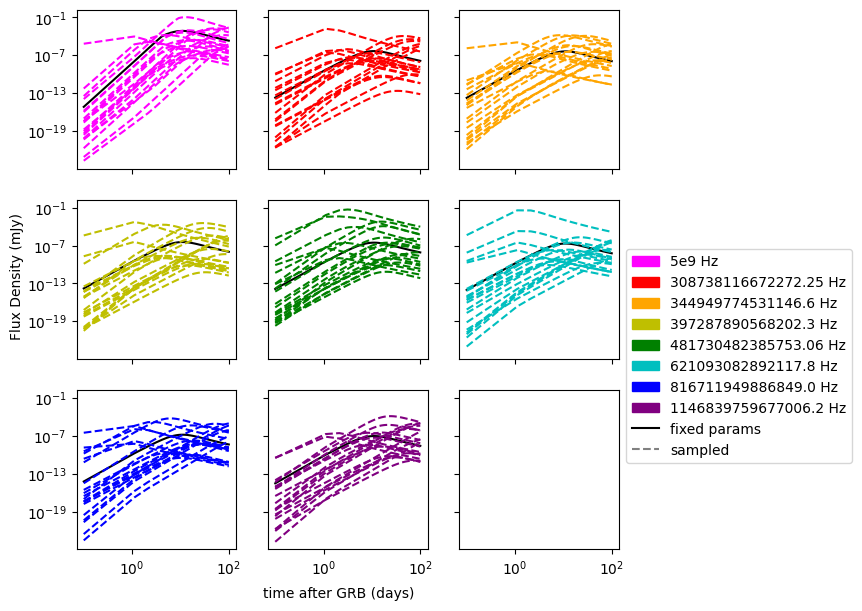

In [37]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowoff(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleoff(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleoff(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleoff(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleoff(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleoff(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleoff(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleoff(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleoff(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')


f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,fix,samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

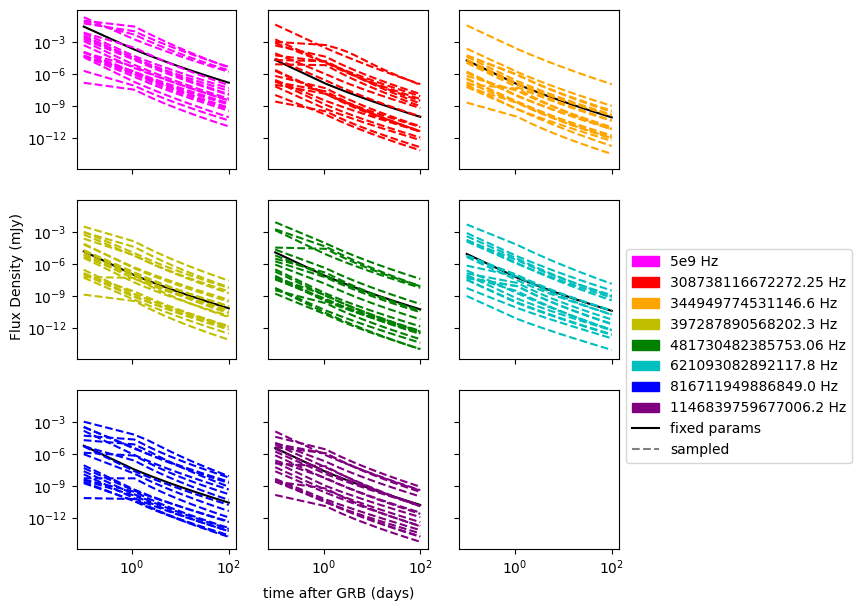

In [6]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleon(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleon(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleon(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleon(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleon(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleon(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleon(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleon(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
    
f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, fix, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

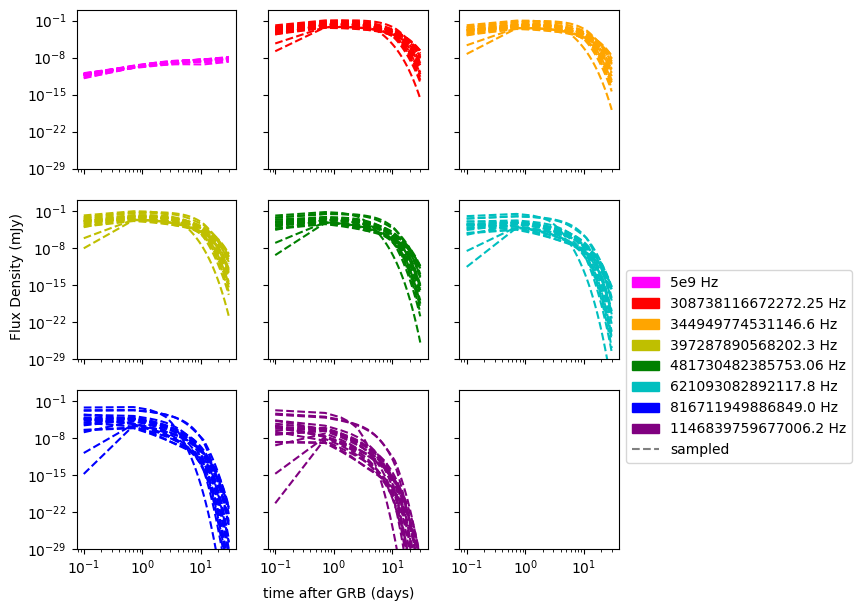

In [30]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

for i in range(20):
    ax[0,0].loglog(time, knsample(time, frequencies[0],**kn_data.iloc[i]), c='magenta', ls='--')
    ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[i]), c='r', ls='--')
    ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[i]), c='orange', ls='--')
    ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[i]), c='y', ls='--')
    ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[i]), c='g', ls='--')
    ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[i]), c='c', ls='--')
    ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[i]), c='b', ls='--')
    ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[i]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
plt.ylim(10e-30,10) 

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

TypeError: two_layer_stratified_kilonova() missing 6 required positional arguments: 'redshift', 'mej', 'vej_1', 'vej_2', 'kappa', and 'beta'

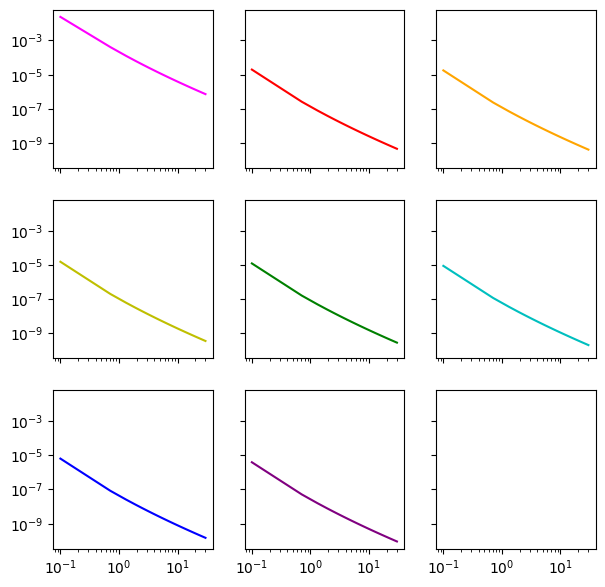

In [38]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowon(time, frequencies[0]) + knsample(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]) + knsample(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]) + knsample(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]) + knsample(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]) + knsample(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]) + knsample(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]) + knsample(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]) + knsample(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')
